### C++ Function with C ABI

We define a **minimal C++ function** and expose it via the **C Application Binary Interface (ABI)**.

Key points:
- `extern "C"` disables C++ name mangling
- The function uses only plain C-compatible types
- This makes the function callable from Python via `ctypes`

This is conceptually identical to `bind(C)` in Fortran.

In [1]:
%%writefile cpp_interface.cpp
#include <cmath>

extern "C" double f_sin_over_1px2(double x)
{
    return std::sin(x) / (1.0 + x * x);
}

Overwriting cpp_interface.cpp


### Compiling the C++ Code into a Shared Library

The C++ source file is compiled into a **shared library**:

- `.so` on Linux
- `.dylib` on macOS

Flags:
- `-shared` → build shared library
- `-fPIC` → position-independent code (required for dynamic loading)

The result is a binary artifact that Python can load at runtime.

In [2]:
!g++ -shared -fPIC cpp_interface.cpp -o cpp_interface.so

### Loading the C++ Library with `ctypes`

Python loads the shared library at runtime using `ctypes.CDLL`.

Important steps:
- Load the library file
- Declare argument types (`argtypes`)
- Declare return type (`restype`)

This step defines the **contract** between Python and the native code.
If this contract is wrong, crashes or wrong results may occur.

In [3]:
import ctypes
import numpy as np
import matplotlib.pyplot as plt

lib = ctypes.CDLL("./cpp_interface.so")

lib.f_sin_over_1px2.argtypes = [ctypes.c_double]
lib.f_sin_over_1px2.restype  = ctypes.c_double

### Calling the C++ Function from Python

We now:
- Generate input values in NumPy
- Call the C++ function for each value
- Plot the result using Matplotlib

Key idea:
Python orchestrates computation and visualization,
while **numerical evaluation runs in native C++ code**.

This pattern is typical for:
- High-performance kernels
- Legacy code integration
- Scientific ML pipelines

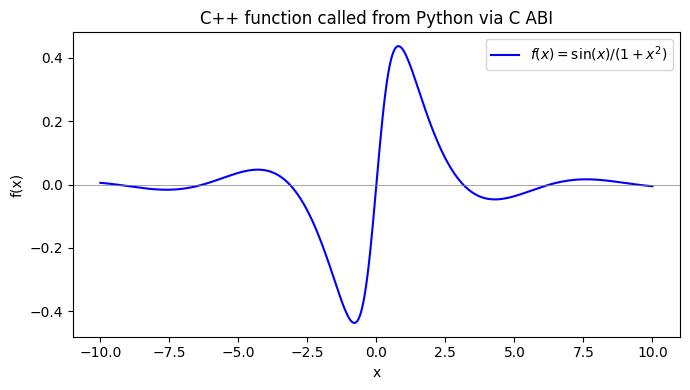

In [6]:
x = np.linspace(-10, 10, 400)
y = np.array([lib.f_sin_over_1px2(xi) for xi in x])

plt.figure(figsize=(7, 4))
plt.plot(x, y, label=r"$f(x)=\sin(x)/(1+x^2)$", color='b')
plt.axhline(0, color="gray", lw=0.5)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("C++ function called from Python via C ABI")
plt.legend()
plt.tight_layout()
plt.savefig("c++_python_sines.png")
plt.show()

### Key Takeaway

Python does not care *which language* computes the result.

It only cares about:
- Binary compatibility (ABI)
- Correct function signatures

This makes Python an ideal **glue language** for
Fortran, C, and C++ in scientific computing and ML.